# Mini-project IIb: How many lines are there  

The overall project goal is to determine how many signal peaks there are in a noisy set of data.

**IMPORTANT:** You will need to use emcee 2.2.1 for this mini-project.  If you have updated to emcee 3.0, you will need to create a conda environment using `environment_emcee_2.2.1.yml` as described here: https://github.com/furnstahl/Physics-8805/blob/master/installation/install.md. (You can see what version of emcee you are using below when it is imported.)

### Learning goals:
* Use advanced Monte Carlo sampling to generate posterior probability distributions and analyze the results.
* Compute an evidence ratio and explain what it means.
* Employ Bayesian evidence for model selection in the context of a prototype for an experimental spectral measurement.

# A spectral line problem

See e.g. section 4.2 in Sivia (see Carmen) for a similar problem formulation. In short, we have data from a spectroscopy experiment that supposedly shows a number of spectral lines. The ideal spectrum, as a function of a scaled coordinate $x$, can be expressed as

$$ G(x) = \sum_{j=1}^M A_j f(x,x_j),$$

where $A_j$ is the amplitude of the $j$th line, and $x_j$ represents its position. If all the spectral lines were Gaussians of width $W$, for example, then

$$ f(x,x_j) = \frac{1}{\sqrt{2\pi W^2}} \exp \left[ - \frac{(x-x_j)^2}{2 W^2} \right]$$

The measurement also includes a background signal which we take to be constant $B(x) = B$. 
 
We use the label '$k$' to enumerate the bins $\{x_k\}$ (do not confuse $x_k$ and $x_j$). The spectrum according to our model is therefore
 
 $$ F_k \equiv F(x_k) = G(x_k) + B.$$

The experimental data is denoted $\{ D_k\}$. This data also includes measurement errors $\varepsilon$ that are assumed to be independent and identically distributed (IID) normal with the same variance $\sigma_\mathrm{exp}$. The measured data is then related to the ideal spectrum by

$$ D_k \equiv D(x_k) = G(x_k) + B + \varepsilon.$$

The task is to infer how many spectral lines ($M$) are in the experimental data, and their positions ($x_j$) and amplitudes ($A_j$). The magnitude of the background is not known before the analysis except that it must be $ \leq 1$.

Using scaled parameters the range of peak positions is $[0,1]$, and the range of amplitudes as well as background is also $[0,1]$.

### Solution strategy:
Our model with $M$ lines has $2M+1$ model parameters that we denote by the vector $\vec{\alpha}$. These are the amplitudes, the positions, and the constant background. We order them as follows:

$$ \vec{\alpha} = (A_0, x_0, A_1, x_1, \ldots, B).$$

The background strength is a *nuisance parameter* in the sense that we're not really interested in its value, we just need to marginalize over it.

### Subtasks (put your answers here):
**For the first two, see Sivia 4.2 if you get stuck.**
1. Formulate the problem of how many lines and what are the model parameters in Bayesian language.
<br><br>
1. Using the expressions from step 1, derive the approximate posterior probability:
$$
p(M | \{ D_k \}, I ) \propto 
\frac{M! (4 \pi)^M }{\left[ x_\mathrm{max} - x_\mathrm{min} \right]^M \left[ A_\mathrm{max} - A_\mathrm{min} \right]^M \sqrt{\det(\boldsymbol\nabla \boldsymbol\nabla \chi^2)} } 
\exp \left( - \frac{\chi^2_\mathrm{min}}{2} \right).
$$
<br><br>
1. **Bonus:** Explain how you might compute this probability numerically using Python. For this imagined numerical implementation you should consider that some model parameters enter non-linearly in your likelihood. (Note: you do not need to implement this calculation.)
<br><br>
1. Generate data using the code snippet below, but plan to change values to explore the dependence of the analysis on the number and relative position of peaks, noise, background, etc. Note that the random seed is initialized to specific values in this notebook. You should start with this example, but should then run the data generator several times to observe the degree of fluctuation.
<br><br>
1. First let's see what happens with ordinary sampling to perform parameter estimation. Run the code below that uses emcee (our favorite MCMC sampler) for first one and then two signal peaks (`numpeaks = 1` then `2`). Comment on the posterior pdf (note that this is the full posterior now, not an approximation) in the two cases for the first corner plot and then the second. What is the difference between these plots? (Hint: what is the reason the first plot is multimodal when the model has two peaks?)
<br><br>
1. Run the parallel tempering code to compute the log evidence for a model with $M$ peaks, looking at $M$ from 1 to 4.  Fill in your results in the table here.  What are your conclusions about the number of peaks based on the evidence?  Does the evidence have a clear maximum or does it saturate?  Connect this result to the in-class discussion.
<br><br>

| numpeaks | log evidence |
|:--------:| :------: |
| 1        |   &nbsp; |
| 2        |   &nbsp; |
| 3        |   &nbsp; |
| 4        |   &nbsp; |




7. **For a plus:** Repeat the parallel tempering calculation and discussion but for data with three peaks and smaller width and noise.
<br><br>

| numpeaks | log evidence |
|:--------:| :------: |
| 1        |   &nbsp; |
| 2        |   &nbsp; |
| 3        |   &nbsp; |
| 4        |   &nbsp; |



## Import statements

In [3]:
%matplotlib inline
import numpy as np
import scipy.stats, scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set default plot styles

import emcee
#from emcee import PTSampler
import corner
#print('Running on emcee v{}'.format(emcee.__version__))

import ptemcee

## Generate data

### Parameters known before the analysis (explore different values for these as requested)

In [4]:
# Width W and noise sigma_exp
W = 0.12  # to try: switch to 0.10 # The width of the spectral lines
sigma_exp = 0.4  # to try: switch to 0.2 # Variance of IID experimental errors 

In [5]:
# Fixed prior ranges (Don't change these)
xmin=0; xmax=1;
Amin=0; Amax=1;
Bmax=1.;

### Parameters that should be learned from the data

In [6]:
np.random.seed(3) # Uncomment to reproduce the same data

# Number of lines
M = 2 

# Amplitudes of the spectral lines
A0 = 10**np.random.uniform(low=-.5, high=0, size=M) 

# Positions of the spectral lines
X0 = np.ones(M)*np.random.uniform(low=.1, high=.4, size=1) 

# Special treatment to place the lines close together
for i in np.arange(1,M):
    X0[i] += np.random.normal(loc=.3,scale=.1)
    X0[i] = min(0.95,X0[i])
    X0[i] = max(0.05,X0[i])

B = np.random.uniform(0.05, 0.8) # A constant background signal

print("True values:   Peak amplitude     Peak position")
print("-----------    --------------     -------------")
for iM in range(M):
    print(f"     peak #{iM}             {A0[iM]:.2f}              {X0[iM]:.2f}  ")
print(f" Background:             {B:.2f}")

True values:   Peak amplitude     Peak position
-----------    --------------     -------------
     peak #0             0.60              0.19  
     peak #1             0.71              0.59  
 Background:             0.72


In [7]:
# Define a truths array that will be of length 2*M + 1
truths = np.empty((2*X0.size + 1,), dtype=X0.dtype)
truths[-1] = B
truths[0:-1:2] = A0
truths[1:-1:2] = X0

# Define a labels list with parameter names
labels = []
for iM in range(M):
    labels.append(f"$A_{iM}$")
    labels.append(f"$X_{iM}$")
labels.append(f"$B$")

In [8]:
def f(x,x0,w):
    '''Simple Gaussian line shape. Position x0, width w.'''
    return np.exp(- (x-x0)**2 / (2 * w**2)) / np.sqrt(2*np.pi*w**2)

def G(x,amplitudes,positions,width=W):
    '''Ideal spectrum composed of N spectral lines with input amplitudes 
    and positions (arrays of length N), and a single, fixed width.'''
    ideal = np.zeros_like(x)
    for a,x0 in zip(amplitudes,positions):
        ideal += a * f(x,x0,width)
    return ideal

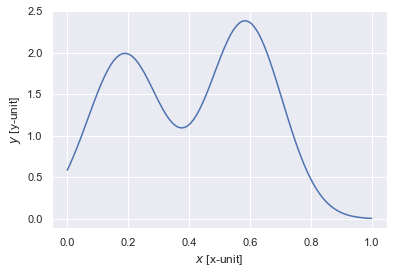

In [9]:
x=np.linspace(xmin,xmax,100)
plt.plot(x,G(x,A0,X0,W))
plt.xlabel('$x$ [x-unit]')
plt.ylabel('$y$ [y-unit]');

Assert: 
1. unknown constant background ($B\le 1$), unknown number of spectral lines with unknown amplitudes and positions.
2. known, natural width (W) of the spectral lines
3. known variance ($\sigma_\mathrm{exp}$) for the IID normal experimental errors
4. known and relevant interval:
   peak positions within [xmin=0, xmax=1] in position space, 
   peak amplitudes within [Amin=0, Amax=1], 

In [10]:
print(f'Natural width of spectral lines:                W = {W}')
print(f'Variance for IID normal exp errors:             s = {sigma_exp}')
print(f'Relevant range in position space:    [xmin, xmax] = [{xmin:.1f}, {xmax:.1f}]')
print(f'Relevant range for peak amplitudes:  [Amin, Amax] = [{Amin:.1f}, {Amax:.1f}]')

Natural width of spectral lines:                W = 0.12
Variance for IID normal exp errors:             s = 0.4
Relevant range in position space:    [xmin, xmax] = [0.0, 1.0]
Relevant range for peak amplitudes:  [Amin, Amax] = [0.0, 1.0]


In [11]:
# Generate experimental data
np.random.seed(42) # For reproducibility.  Set 42 to 0 for different values.
Ndata = 100 # Number of data points
xk = np.linspace(xmin, xmax, Ndata)
sk=np.ones_like(xk) * sigma_exp # We assume that the variance is the same for all k
ek = np.random.normal(loc=0.0, scale=sigma_exp, size=Ndata)
Dk = G(xk,A0,X0,W) + B + ek
# Data saved in a file (but also printed below)
data = [xk,Dk,sk]

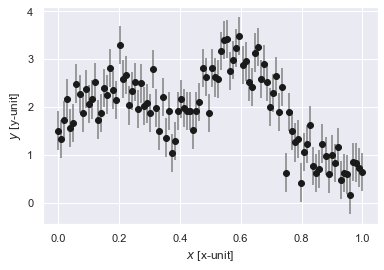

In [12]:
plt.errorbar(xk,Dk,yerr=sk,fmt='ok',ecolor='gray')
plt.xlabel('$x$ [x-unit]')
plt.ylabel('$y$ [y-unit]');

## Parameter estimation with your favorite MCMC sampler (emcee here!)

We will use an MCMC to draw samples from the posterior in order to solve the model fitting problem. We will use the emcee package, which requires us to first define functions which compute the prior, likelihood, and posterior under each model.  The model is determined by the number of peaks, which in turn defines the dimension of the model (an amplitude and a location to determine for each peak, plus the background amplitude).

### emcee

In [13]:
# Uniform priors for parameters

def log_prior(alpha):
    '''Logarithm of prior.
    
    Flat priors over predetermined ranges
    The size of alpha determines the model.
    Amplitudes are elements 0, 2, 4, ..., [0:-1:2]
    Positions are elements 1,3,5, ...     [1:-1:2]
    Background is the last element.    [-1]
    '''
    
    # All parameters must be positive
    if np.any(alpha < 0):
        return -np.inf  # log(0)
    # All amplitudes are assumed to be smaller than Amax
    elif np.any(alpha[0:-1:2] > Amax):
        return -np.inf
    # The positions are assumed to be in the [xmin, xmax] range
    elif np.any(alpha[1:-1:2] > xmax):
        return -np.inf
    # The background signal is assumed to be smaller than Bmax
    elif alpha[-1] > Bmax:
        return -np.inf
    else:
        return 0 # log(1), note that it is not properly normalized

In [14]:
def model_func(alpha, x=xk, width=W):
    '''Computes the model ideal spectrum Fk'''
    _amplitudes = alpha[0:-1:2]
    _positions = alpha[1:-1:2]
    _background = alpha[-1]
    return G(x,_amplitudes,_positions,width) + _background

def log_likelihood(alpha, data=data):
    '''Logarithm of likelihood function.
    
    Returns the negative sum of the squared residuals, which is
    equivalent to a chi-square measure or the logarithm of a
    gaussian likelihood function.
    '''
    x, y, sigma_y = data
    model_y = model_func(alpha,x=x)
    residuals = (model_y - y) / sigma_y
    return -0.5 * np.sum(residuals**2)

In [15]:
def log_posterior(alpha, data=data):
    '''Logarithm of posterior.'''
    _alpha = np.asarray(alpha)
    return log_prior(_alpha) + log_likelihood(_alpha, data=data)

In [16]:
numpeaks=1 # Number of peaks in the *model*. *** You set this ***
           #  Note how numpeaks determines ndim below.
    
nwalkers=50 
nburn=1000
nsteps=5000

ndim = numpeaks*2 + 1  # this determines the model dimension

starting_guesses = (np.random.rand(nwalkers, ndim) * \
                    np.tile(np.ones(ndim), (nwalkers, 1)))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
trace_unordered = sampler.chain[:, nburn:, :].reshape(-1, ndim)

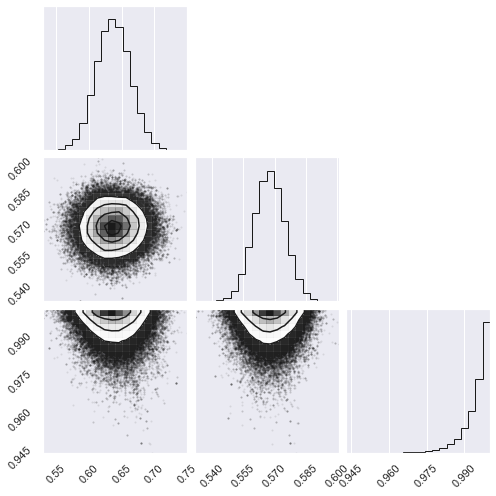

In [17]:
# First a corner plot without the ordered samples
figure = corner.corner(trace_unordered)

In [18]:
trace = np.copy(trace_unordered)

for i, sample in enumerate(trace_unordered):
    # Sort by proposed peak position since (x0,x1,...) is the same as (x1,x0,...)
    x_sort = np.argsort(sample[1:-1:2])*2+1
    sample_sort = np.empty((2*x_sort.size + 1,), dtype=x_sort.dtype)
    sample_sort[-1]=len(sample_sort)-1
    sample_sort[1:-1:2] = x_sort
    sample_sort[0:-1:2] = x_sort-1
    trace[i] = sample[sample_sort]

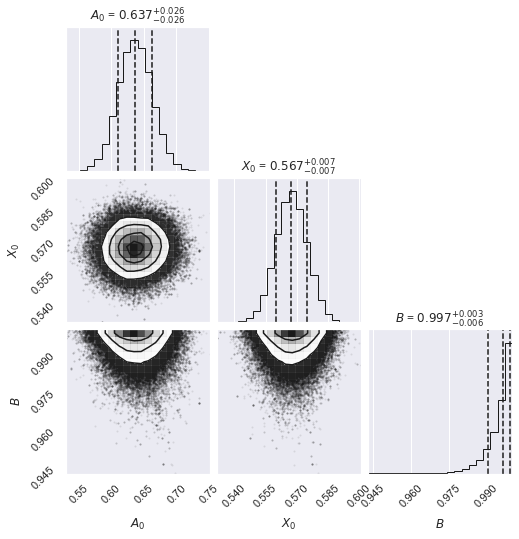

In [19]:
if numpeaks==2:
    truths_corner = truths
else:
    truths_corner = None

# Define a labels list with parameter names
labels_corner = []
for iM in range(numpeaks):
    labels_corner.append(f"$A_{iM}$")
    labels_corner.append(f"$X_{iM}$")
labels_corner.append(f"$B$")

figure = corner.corner(trace[:,:],labels=labels_corner,
                       quantiles=[0.16, 0.5, 0.84],truths=truths_corner,
                       show_titles=True, title_fmt='.3f', title_kwargs={"fontsize": 12})

In [20]:
params = np.percentile(trace_unordered, [16, 50, 84], axis=0)
with np.printoptions(precision=2):
    print(f"True values:", truths) 
    print(f"       MAP:", params[1,:]) 

True values: [0.6  0.19 0.71 0.59 0.72]
       MAP: [0.64 0.57 1.  ]


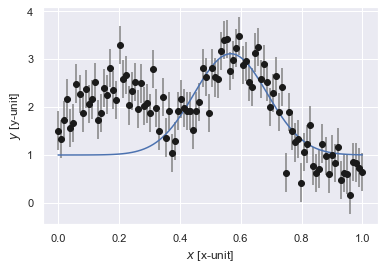

In [21]:
plt.errorbar(xk, Dk, yerr=sk, fmt='ok', ecolor='gray')
x = np.linspace(xmin,xmax,100)
plt.plot(x, G(x,params[1,0:-1:2], params[1,1:-1:2]) + params[1,-1])
plt.xlabel('$x$ [x-unit]')
plt.ylabel('$y$ [y-unit]');

### Using parallel tempering: ptemcee

In [25]:
numpeaks = 1 # Number of peaks in the *model* (step through 1, 2, 3, 4)
             #  Note how this determines ndim below.

In [26]:
# Now we can construct a sampler object that will drive the PTMCMC; 
# in the first pass we chose to use 21 temperatures 
# (the default is for each temperature to increase by a factor of sqrt(2), 
# so the highest temperature will be T=1024, resulting in an effective 
# \sigma_T=32\sigma=3.2, which is about the separation of our modes). 

#ntemps = 21
#temps = np.array([np.sqrt(2)**i for i in range(ntemps)])

# This did not work well, so we modified the temperature ladder to improve 
#  the integration for evidence calculation:
#  need more low temperatures, i.e. finer grid near beta = 1.
ntemps_lo = 8
ntemps_hi = 21
temps_lo = np.array([2**(i/8.) for i in range(ntemps_lo)])
temps_hi = np.array([np.sqrt(2)**i for i in range(ntemps_hi)])
temps = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))
ntemps=len(temps)

betas=1/temps

# Let us use 10 walkers in the ensemble at each temperature:
ndim = numpeaks*2 + 1  # this determines the model dimension
nwalkers = max(10,ndim*2+2)

nburnin=1000
nsteps=5000
nthin = 10 # only record every nthin iteration

nthreads = 1

In [27]:
p0 = np.random.uniform(size=(ntemps, nwalkers, ndim))

In [28]:
sampler = ptemcee.Sampler(nwalkers, ndim, log_likelihood, log_prior, ntemps,
                         threads=nthreads, betas=betas)

In [30]:
#sampler=PTSampler(ntemps, nwalkers, ndim, log_likelihood, log_prior, 
#                  threads=nthreads, betas=betas)

#Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. We could have modified the temperature ladder using the 
# betas optional argument (which should be an array of \beta=1/T values). 

#First, we run the sampler for 1000 burn-in iterations:
print("Running burn-in phase")
for p, lnprob, lnlike in sampler.sample(p0, iterations=nburnin):
    pass
sampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:

for p, lnprob, lnlike in sampler.sample(p, iterations=nsteps, thin=nthin):
    pass 

Running burn-in phase
Running MCMC chains


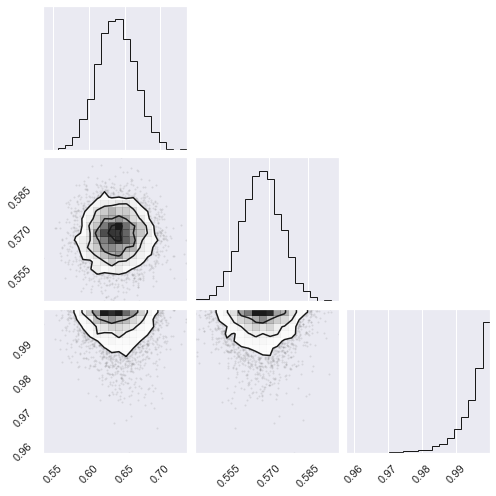

In [31]:
pt_sampler_T0 = sampler.chain[0,...].reshape(-1,ndim)
figure = corner.corner(pt_sampler_T0)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

#### Perform thermodynamic integration from PT sampler

In [32]:
# From PT sampler
(lnZ, dlnZ) = sampler.thermodynamic_integration_log_evidence()
print(f"The log evidence is {lnZ:.3f} +/- {dlnZ:.3f}")
print("NOTE: This thermodynamic integration output from PT Sampler",\
      "may not be very reliable due to poor numerical integration.")
print("Better do it yourself (see below).")

AttributeError: 'Sampler' object has no attribute 'thermodynamic_integration_log_evidence'

In [33]:
# Array with beta values (1/T)
betas = sampler.betas
avg_lnl = np.zeros_like(betas) # averages of log likelihood for different beta
var_lnl = np.zeros_like(betas) # variances of log likelihood for different beta
for ib,b in enumerate(betas):
    avg_lnl[ib] = np.mean(sampler.lnlikelihood[ib,...].reshape(-1))
    var_lnl[ib] = np.var(sampler.lnlikelihood[ib,...].reshape(-1))
    
betas0 = np.concatenate((sampler.betas, np.array([0])))
dbetas = np.diff(betas0)

AttributeError: 'Sampler' object has no attribute 'lnlikelihood'

In [ ]:
plt.plot(betas,avg_lnl,'ko-')
ax=plt.gca()
ymin=np.ones_like(betas)*min(avg_lnl)
ax.fill_between(betas, ymin,avg_lnl,facecolor='green', alpha=0.1)
fig=plt.gcf()
#ax.set_ylim([-100,-30]);
ax.set_xlim([0.,1.05]);
ax.set_xlabel(r'$\beta$');
ax.set_ylabel(r'$\ln\left(Z(\beta)\right)$');

In [ ]:
print("Integrate using trapezoid approximation with N={} points".format(ntemps))
print("from {:.4e} to {:.4e}".format(betas0[0],betas0[-1]))
lnzl = -np.trapz(avg_lnl, x=betas)
print(f"\nWe find log-evidence = {lnzl:7.4f}".format())
